# Модель классификации картинок

Хотелось научить модель отличать Гослинга от Рэйнольдса, но она не получилась, поэтому решила вернуться к проверенной классической задаче cats vs dogs, в нашем случае мемы с котиками против мемов с волками. Простая бинарная классификация.

Для начала распакуем картинки из архивов и разделим их на train, val, test.

In [1]:
!pip install -q keras

In [2]:
import os
import pandas as pd
import requests
from numpy import char
import time
from PIL import Image
from io import BytesIO
import os, random, shutil
from PIL import UnidentifiedImageError

def download_and_convert_image(url, filename):
  try:
    response = requests.get(url)
    if response.status_code == 200:
      image = Image.open(BytesIO(response.content))
      image.convert('RGB').save(filename + '.png', format='PNG')
    else:
      print(f"Error: Unable to download image from the {url}")
  except UnidentifiedImageError:
    pass

def download_df(df, directory, filepref = ''):
  if not os.path.exists(directory):
    os.makedirs(directory)
  for i in range(len(df.axes[0])):
    download_and_convert_image(df.loc[i][0], directory + '/' + filepref + str(i))


In [3]:
import random
import shutil
import numpy as np

def train_val_test_split(directory, max_num_files = 1000, train_per=0.8, test_per=0.1):
  folder = directory.split("/")[-2]
  if not os.path.exists('/content/data/train/'+folder):
    os.makedirs('/content/data/train/'+folder)
  if not os.path.exists('/content/data/val/'+folder):
    os.makedirs('/content/data/val/'+folder)
  if not os.path.exists('/content/data/test/'+folder):
    os.makedirs('/content/data/test/'+folder)
  num_files = min(len(os.listdir(directory)), max_num_files)
  print(num_files)
  n_train = round(num_files * train_per)
  n_test = round(num_files * test_per)
  random.seed(0)
  file_list = os.listdir(directory)
  for i in range(num_files):
    file = file_list.pop(random.randint(0, len(file_list)-1))
    if i < n_train:
      shutil.copy(directory + file, '/content/data/train/' + folder + '/' + file)
    elif i < n_train + n_test:
      shutil.copy(directory + file, '/content/data/test/' + folder + '/' + file)
    else:
      shutil.copy(directory + file, '/content/data/val/' + folder + '/' + file)



In [4]:
df_cat = pd.read_csv("data_cat.csv")
df_cat = df_cat.drop('Unnamed: 0', axis=1)
download_df(df_cat, '/content/cat/', 'cat')

In [70]:
train_val_test_split('/content/cat/', 600)

600


In [55]:
df_wolf = pd.read_csv("data_wolf.csv")
df_wolf = df_wolf.drop('Unnamed: 0', axis=1)
download_df(df_wolf, '/content/wolf/', 'wolf')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [71]:
train_val_test_split('/content/wolf/', 600)

600


Теперь у нас есть папки с картинками для каждого множества.
Добавитм аугментацию. Сделаем это автоматизированно с помощью ImageDataGenerator.

In [76]:
from keras.preprocessing.image import ImageDataGenerator

IMGWIDTH = 300
IMGHEIGHT = 300
BATCHSZ = 32

train_generator = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest')

train_data = train_generator.flow_from_directory(
    '/content/data/train',
    target_size=(IMGWIDTH, IMGHEIGHT),
    batch_size=BATCHSZ,
    class_mode='binary',
    seed=0)

test_generator = ImageDataGenerator()

val_data = test_generator.flow_from_directory(
    '/content/data/val',
    target_size=(IMGWIDTH, IMGHEIGHT),
    batch_size=BATCHSZ,
    class_mode='binary',
    seed=0)

test_data = test_generator.flow_from_directory(
    '/content/data/test',
    target_size=(IMGWIDTH, IMGHEIGHT),
    batch_size=30,
    class_mode='binary',
    seed=0)

Found 960 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Отлично, данные, помеченные на 2 класса есть.
Теперь создадим класс для модели. За основу возьмем предобученную keras Sequential.

In [80]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Rescaling
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import MobileNetV2
from keras import Input, Model
from keras.optimizers import SGD

class MModel():
  def __init__(self):
    base_model = MobileNetV2(
      weights='imagenet',
      input_shape=(IMGWIDTH, IMGHEIGHT, 3),
      include_top=False,
      classes=2)
    base_model.trainable = False
    inputs = Input(shape=(IMGWIDTH, IMGHEIGHT, 3))
    scale_layer = Rescaling(scale=1 / 127.5, offset=-1)
    x = base_model(scale_layer(inputs), training=False)
    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    outputs = x = Activation('sigmoid')(x)
    self.model = Model(inputs, outputs)
    self.model.compile(
        loss = 'binary_crossentropy',
        metrics = ['accuracy'],
        optimizer = 'rmsprop')

  def fit(self, train_data, val_data, epochs, callbacks=None):
    return self.model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks)

  def summary(self):
    print(self.model.summary())

  def evaluate(self, data):
    return self.model.evaluate(data)

  def predict(self, data):
    return self.model.predict(data)

  def save(self, filename):
    self.model.save(filename)

In [78]:
random.seed(0)
np.random.seed(0)

Создадим экземпляр модели и выведем ее слои.

In [81]:
model = MModel()
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 32)          368672    
                                                                 
 activation_44 (Activation)  (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 4, 4, 32)          0         
 ng2D)                                                    

Теперь собственно переходим к обучению модели.

Делаем это блоками по 5 эпох, чтобы получать промежуточные результаты (сохраняем модель после каждого блока, на всякий случай).

In [82]:
from keras.callbacks import TensorBoard
from datetime import datetime

EPOCHS = 10
acc_history = []
tensorboard_cbk = TensorBoard(log_dir='/logs/scalars/' + datetime.now().strftime("%Y%m%d-%H%M%S"), update_freq='epoch')

In [83]:
train_history = model.fit(train_data, val_data, EPOCHS, [tensorboard_cbk])
model.save("model1.h5")
acc_history.append(train_history.history['accuracy'])

Epoch 1/10
30/30 [==============================] - 159s 5s/step - loss: 0.3783 - accuracy: 0.8750 - val_loss: 0.0239 - val_accuracy: 0.9917
Epoch 2/10
30/30 [==============================] - 145s 5s/step - loss: 0.0936 - accuracy: 0.9677 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 3/10
30/30 [==============================] - 188s 6s/step - loss: 0.0415 - accuracy: 0.9854 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 4/10
30/30 [==============================] - 149s 5s/step - loss: 0.0701 - accuracy: 0.9781 - val_loss: 0.0233 - val_accuracy: 0.9917
Epoch 5/10
30/30 [==============================] - 154s 5s/step - loss: 0.0294 - accuracy: 0.9875 - val_loss: 0.0118 - val_accuracy: 0.9917
Epoch 6/10
30/30 [==============================] - 165s 5s/step - loss: 0.0560 - accuracy: 0.9865 - val_loss: 0.0232 - val_accuracy: 0.9917
Epoch 7/10
30/30 [==============================] - 172s 6s/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.0112 - val_accuracy: 0.9917
Epoch 8/10
30

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0, 0.5, 'Accuracy value')

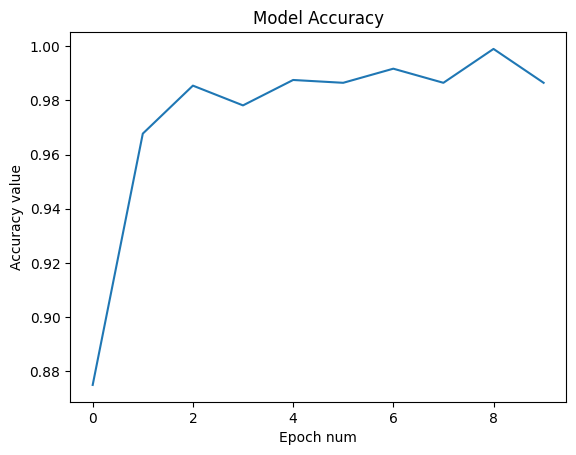

In [88]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch num')
plt.ylabel('Accuracy value')

In [91]:
print(f'Test scores:\n\t')
test_scores = model.evaluate(test_data)
print(f'Val scores:\n\t')
val_scores = model.evaluate(val_data)

Test scores:
	
4/4 [==============================] - 15s 3s/step - loss: 5.2991e-04 - accuracy: 1.0000
Val scores:
	
4/4 [==============================] - 12s 3s/step - loss: 3.2468e-04 - accuracy: 1.0000


Метрика точности равна 1 и для тестового и для валидационного множества. Выглядит удивительно.

In [69]:
%rm -rf /content/data